https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [ ]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [ ]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [ ]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [ ]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [ ]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv = conv3x3(in_channels=3, out_channels=64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=64, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=128, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=256, blocks=layers[2], stride=2)
        # self.layer4 = self.make_layer(block=block, out_channels=512, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    # return ResNet(ResidualBlock, [2, 2, 2, 2])
    return ResNet(ResidualBlock, [3, 3, 2])

In [ ]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [ ]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [ ]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

In [ ]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [ ]:
import pandas

def save_to_csv(csvname, train_losses, train_accs, test_losses, test_accs):
  df = pandas.DataFrame()
  df["epoch"] = [i+1 for i in range(len(train_losses))]
  df["train_loss"] = train_losses
  df["test_loss"] = test_losses
  df["train_acc"] = train_accs
  df["test_acc"] = test_accs
  df.to_csv(csvname)

In [ ]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 80

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    scheduler.step(train_losses[-1])
    # scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")

    save_to_csv("6_resnet_3_3_2_inchannels_64.csv", train_losses, train_acc, test_losses, test_acc)


EPOCHS : 0


Batch_id=87 Batch Loss=0.020295776426792145 Running Loss=2.8374652825295925 Running Accuracy=99.00: 100%|██████████| 88/88 [00:48<00:00,  1.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4584/5000 (91.68%)


Test set: Average loss: 0.3177, Accuracy: 9168/10000 (91.68%)

EPOCHS : 1


Batch_id=87 Batch Loss=0.02555971033871174 Running Loss=2.4477309361100197 Running Accuracy=99.16: 100%|██████████| 88/88 [00:47<00:00,  1.84it/s]



Validation set: Average loss: 0.0006, Accuracy: 4588/5000 (91.76%)


Test set: Average loss: 0.3091, Accuracy: 9161/10000 (91.61%)

EPOCHS : 2


Batch_id=87 Batch Loss=0.02587435394525528 Running Loss=2.364615094847977 Running Accuracy=99.22: 100%|██████████| 88/88 [00:48<00:00,  1.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4602/5000 (92.04%)


Test set: Average loss: 0.3087, Accuracy: 9188/10000 (91.88%)

EPOCHS : 3


Batch_id=87 Batch Loss=0.03462431579828262 Running Loss=2.1586476378142834 Running Accuracy=99.31: 100%|██████████| 88/88 [00:48<00:00,  1.83it/s]



Validation set: Average loss: 0.0006, Accuracy: 4610/5000 (92.20%)


Test set: Average loss: 0.3065, Accuracy: 9194/10000 (91.94%)

EPOCHS : 4


Batch_id=87 Batch Loss=0.02545597031712532 Running Loss=2.120497397147119 Running Accuracy=99.27: 100%|██████████| 88/88 [00:48<00:00,  1.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4615/5000 (92.30%)


Test set: Average loss: 0.3039, Accuracy: 9194/10000 (91.94%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.01989830657839775 Running Loss=2.006734729744494 Running Accuracy=99.41: 100%|██████████| 88/88 [00:48<00:00,  1.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4611/5000 (92.22%)


Test set: Average loss: 0.3071, Accuracy: 9200/10000 (92.00%)

EPOCHS : 6


Batch_id=87 Batch Loss=0.02089650370180607 Running Loss=2.047381989657879 Running Accuracy=99.30: 100%|██████████| 88/88 [00:48<00:00,  1.83it/s]



Validation set: Average loss: 0.0006, Accuracy: 4613/5000 (92.26%)


Test set: Average loss: 0.3040, Accuracy: 9201/10000 (92.01%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.022289546206593513 Running Loss=1.987716931849718 Running Accuracy=99.34: 100%|██████████| 88/88 [00:48<00:00,  1.83it/s]



Validation set: Average loss: 0.0006, Accuracy: 4614/5000 (92.28%)


Test set: Average loss: 0.3018, Accuracy: 9191/10000 (91.91%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.04828300327062607 Running Loss=1.8960581421852112 Running Accuracy=99.38: 100%|██████████| 88/88 [00:48<00:00,  1.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4614/5000 (92.28%)


Test set: Average loss: 0.3035, Accuracy: 9208/10000 (92.08%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.02888374961912632 Running Loss=1.8264388218522072 Running Accuracy=99.44: 100%|██████████| 88/88 [00:48<00:00,  1.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4610/5000 (92.20%)


Test set: Average loss: 0.3077, Accuracy: 9199/10000 (91.99%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.021002449095249176 Running Loss=1.7348744049668312 Running Accuracy=99.48: 100%|██████████| 88/88 [00:48<00:00,  1.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4607/5000 (92.14%)


Test set: Average loss: 0.3048, Accuracy: 9204/10000 (92.04%)

EPOCHS : 11


Batch_id=87 Batch Loss=0.023895394057035446 Running Loss=1.8318154467269778 Running Accuracy=99.41: 100%|██████████| 88/88 [00:48<00:00,  1.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4606/5000 (92.12%)


Test set: Average loss: 0.3070, Accuracy: 9204/10000 (92.04%)

EPOCHS : 12


Batch_id=87 Batch Loss=0.017652038484811783 Running Loss=1.673042694106698 Running Accuracy=99.50: 100%|██████████| 88/88 [00:49<00:00,  1.79it/s]



Validation set: Average loss: 0.0006, Accuracy: 4610/5000 (92.20%)


Test set: Average loss: 0.3032, Accuracy: 9204/10000 (92.04%)

EPOCHS : 13


Batch_id=87 Batch Loss=0.029181623831391335 Running Loss=1.7993319826200604 Running Accuracy=99.38: 100%|██████████| 88/88 [00:48<00:00,  1.83it/s]



Validation set: Average loss: 0.0006, Accuracy: 4610/5000 (92.20%)


Test set: Average loss: 0.3056, Accuracy: 9200/10000 (92.00%)

EPOCHS : 14


Batch_id=87 Batch Loss=0.022970790043473244 Running Loss=1.708978770300746 Running Accuracy=99.48: 100%|██████████| 88/88 [00:48<00:00,  1.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4600/5000 (92.00%)


Test set: Average loss: 0.3060, Accuracy: 9208/10000 (92.08%)

EPOCHS : 15


Batch_id=87 Batch Loss=0.020333165302872658 Running Loss=1.6811189576983452 Running Accuracy=99.51: 100%|██████████| 88/88 [00:48<00:00,  1.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4615/5000 (92.30%)

Epoch 00096: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.3039, Accuracy: 9202/10000 (92.02%)

EPOCHS : 16


Batch_id=87 Batch Loss=0.013128465041518211 Running Loss=1.6115682506933808 Running Accuracy=99.49: 100%|██████████| 88/88 [00:48<00:00,  1.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4612/5000 (92.24%)


Test set: Average loss: 0.3051, Accuracy: 9209/10000 (92.09%)

EPOCHS : 17


Batch_id=87 Batch Loss=0.021889304742217064 Running Loss=1.5917547503486276 Running Accuracy=99.52: 100%|██████████| 88/88 [00:48<00:00,  1.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4607/5000 (92.14%)


Test set: Average loss: 0.3054, Accuracy: 9206/10000 (92.06%)

EPOCHS : 18


Batch_id=87 Batch Loss=0.013617685995995998 Running Loss=1.5944876205176115 Running Accuracy=99.55: 100%|██████████| 88/88 [00:48<00:00,  1.83it/s]



Validation set: Average loss: 0.0006, Accuracy: 4609/5000 (92.18%)


Test set: Average loss: 0.3044, Accuracy: 9211/10000 (92.11%)

EPOCHS : 19


Batch_id=87 Batch Loss=0.018261194229125977 Running Loss=1.5890787793323398 Running Accuracy=99.55: 100%|██████████| 88/88 [00:48<00:00,  1.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4603/5000 (92.06%)


Test set: Average loss: 0.3057, Accuracy: 9206/10000 (92.06%)

EPOCHS : 20


Batch_id=87 Batch Loss=0.011725700460374355 Running Loss=1.553102736826986 Running Accuracy=99.53: 100%|██████████| 88/88 [00:48<00:00,  1.83it/s]



Validation set: Average loss: 0.0006, Accuracy: 4609/5000 (92.18%)


Test set: Average loss: 0.3054, Accuracy: 9209/10000 (92.09%)

EPOCHS : 21


Batch_id=87 Batch Loss=0.009077190421521664 Running Loss=1.5837615793570876 Running Accuracy=99.52: 100%|██████████| 88/88 [00:48<00:00,  1.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4608/5000 (92.16%)


Test set: Average loss: 0.3049, Accuracy: 9211/10000 (92.11%)

EPOCHS : 22


Batch_id=87 Batch Loss=0.04348639398813248 Running Loss=1.5623280522413552 Running Accuracy=99.55: 100%|██████████| 88/88 [00:48<00:00,  1.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4603/5000 (92.06%)


Test set: Average loss: 0.3058, Accuracy: 9203/10000 (92.03%)

EPOCHS : 23


Batch_id=87 Batch Loss=0.023388097062706947 Running Loss=1.5441596088930964 Running Accuracy=99.53: 100%|██████████| 88/88 [00:48<00:00,  1.83it/s]



Validation set: Average loss: 0.0006, Accuracy: 4611/5000 (92.22%)



In [ ]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)

FileNotFoundError: ignored

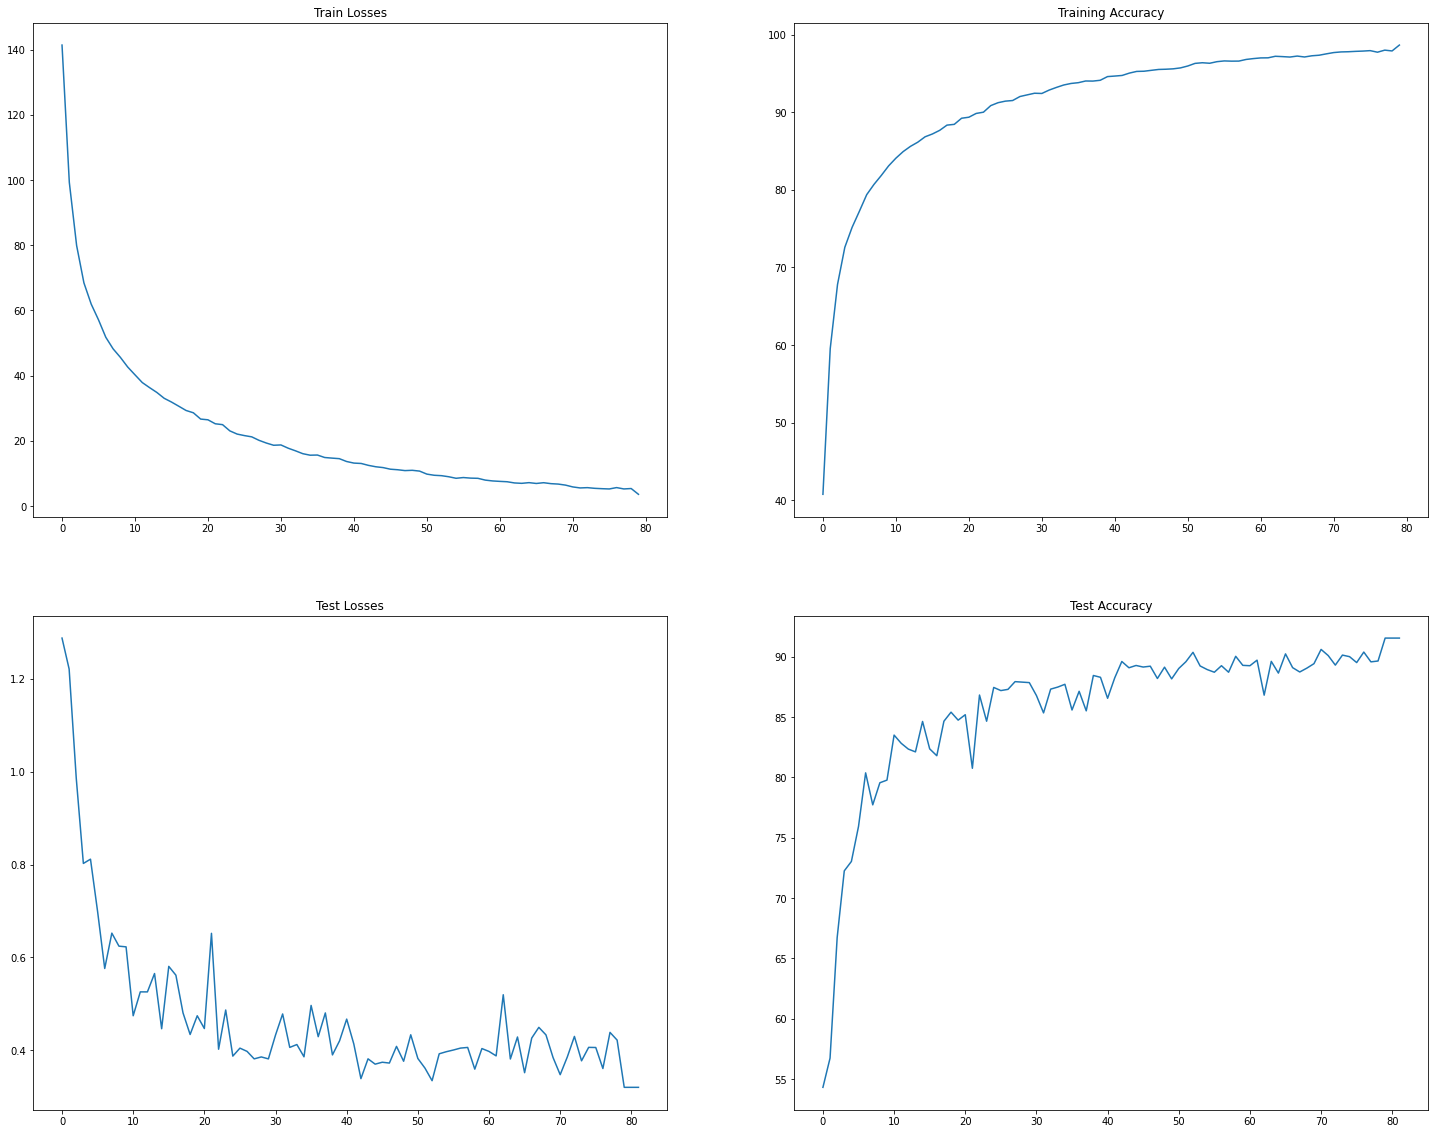

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)